Assign8: Clustering: EM and K-Means
Due Date: Nov 22, before midnight (11:59:59PM)

You will use the Codon Usage Dataset. You should use Column 1 as the true cluster label. Next ignore Columns 2, 3, 4, and 5. Use the remaining 64 attributes as the 64 dimensional feature vector per point. Since Column 1 is the animal kingdom, you are trying to group the points based on the DNA codon frequencies. Also, there are some data errors on lines 488 and 5065 (if header is assumed to be line 1). You should ignore those lines after reading in the data (do not modify the input file).

CSCI4390/6390: Expectation Maximization Clustering
Implement the Expectation-Maximization (EM) algorithm for clustering (see Algorithm 13.3 in Chapter 13). Use Col 1 as the true cluster labels, so there are 11 true clusters, and you should use k=11k=11 to show results.

For initializing the clusters, select kk random data points as the cluster centers. However, once you have chosen the centers, assign each point to the closest center to compute the covariance matrix and the prior probabilities of each cluster.

For practical purposes, you may want to use the logexpsum trick for expectation step, where you compute the log probabilities so that you can deal with very small probability values, otherwise, you may find that weights of a point for the clusters are zero. That is, if all probabilities are given as logP(Ci)logP(Ci) and logP(xj∣Ci)logP(xj∣Ci), then we have first compute logw′ij=logP(xj∣Ci)+logP(Ci)logw 
ij
′
​
 =logP(xj∣Ci)+logP(Ci) (note: this is only the numerator, we have to normalize as given below). But, to compute the final wijw 
ij
​
 , we have to use the logsumexp trick, since
logsumexp(logw′1j,logw′2j,...,logw′kj)=log(∑ka=1explogw′aj)=log(∑ka=1w′aj)
logsumexp(logw 
1j
′
​
 ,logw 
2j
′
​
 ,...,logw 
kj
′
​
 )=log( 
a=1
∑
k
​
 explogw 
aj
′
​
 )=log( 
a=1
∑
k
​
 w 
aj
′
​
 )
And therefore,
wij=exp(logw′ij−logsumexp(logw′1j,...,logw′kj))
w 
ij
​
 =exp(logw 
ij
′
​
 −logsumexp(logw 
1j
′
​
 ,...,logw 
kj
′
​
 ))
You can therefore use scipy.special.logsumexp function on log probabilities.

As another practical point, you can get an error when inverting the covariance matrix, so you should add a small ridge value λλ value along the diagonal entries to make the matrix invertible. This can be considered as a regularized estimate of the covariance matrix, i.e.,
Σ+λI
Σ+λI
Or just use scipy.stats.multivariate_normal.logpdf with allow_singular flag set to True.

Your program output should consist of the following information:

The final mean for each cluster
The final covariance matrix for each cluster
Size of each cluster, after assigning each point to the cluster with highest posterior probability P(ci∣xj)P(c 
i
​
 ∣x 
j
​
 ).
The Normalized Mutual Information (NMI) score for your clustering, computed using Eq. 17.8. You must implement this on your own.
Run your code at least 10 times with different random initial clusters, and report the clustering with the best NMI score.

CSCI6390 Only: K-Means
In addition, implement the basic K-Means algorithm 13.1 on pg 336.

To initialize the clusters select kk random points as means.

Your code must output the following information:

The mean and size of each cluster
The NMI value for your clustering
Run your code at least 10 times with different random initial clusters, and report the clustering with the best NMI score.

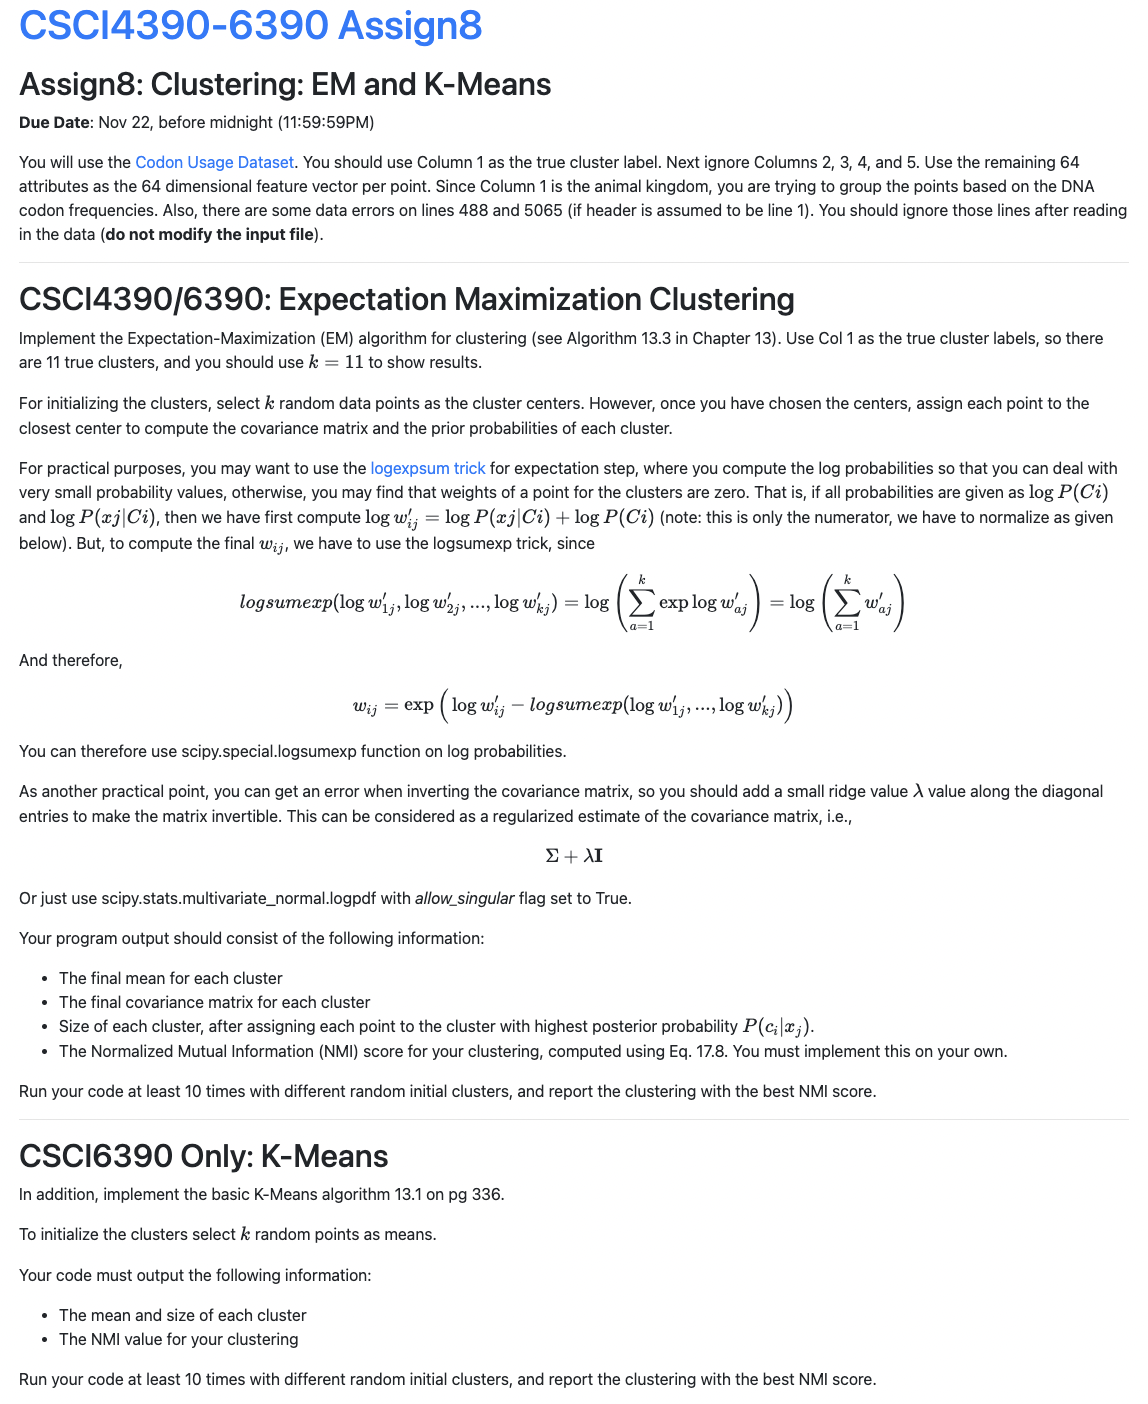

# EM clustering

In [3]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
import random

In [4]:
invalid = [1,2,3,4]
cols = [i for i in range(69) if i not in invalid]
df = pd.read_csv("codon_usage.csv", usecols=cols)
#print(df.describe())
#print(df.columns)
D = df.to_numpy()
print(D.shape)
D = np.delete(D, 486, 0)
D = np.delete(D, 5062, 0)
print(D.shape)

(13028, 65)
(13026, 65)


/var/folders/gb/hwvzzncj2f9fs4sfs8f7q2vh0000gn/T/ipykernel_3361/2238818590.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv", usecols=cols)


In [6]:
Y = D[:,0]
X = D[:,1:]

In [10]:
pd.unique(Y)

'vrl'

In [5]:
D

array([['vrl', '0.01654', '0.01203', ..., 0.00251, 0.0005, 0.0],
       ['vrl', '0.02714', '0.01357', ..., 0.00271, 0.00068, 0.0],
       ['vrl', '0.01974', '0.0218', ..., 0.00391, 0.0, 0.00144],
       ...,
       ['pri', 0.01423, 0.03321, ..., 0.00356, 0.00119, 0.02017],
       ['pri', 0.01757, 0.02028, ..., 0.00099, 0.00079, 0.00156],
       ['pri', 0.01778, 0.03724, ..., 0.00156, 0.00114, 0.02161]],
      dtype=object)

In [14]:
d = dict(zip(list(pd.unique(Y)), range(0,11)))
d
df1 = pd.DataFrame(Y)
df1[0].map(d, na_action='ignore')

0         0
1         0
2         0
3         0
4         0
         ..
13021    10
13022    10
13023    10
13024    10
13025    10
Name: 0, Length: 13026, dtype: int64

In [409]:
Xi = []
n,d = X.shape
for i in range(n):
    row = []
    for j in range(d):
        row.append(float(X[i,j]))
    Xi.append(row)

In [410]:
X = np.array(Xi)

In [411]:
np.unique(Y,return_counts=True)[1]

array([ 126, 2919, 1345,  572,  220,   18, 2523,  180,  215, 2831, 2077])

In [ ]:
def initialize(data,clusters):
    n,d = data.shape
    means = select_random_points(data,clusters)
    cov = []
    for i in range(clusters):
        cov.append(np.eye(d))
    cov = np.array(cov)
    pci = np.ones(clusters)*(1/clusters)
    return means,cov,pci


def Estep(X, k, mu, cov, p):
    n, d = X.shape
    w = np.zeros((n, k))
    v = np.zeros((n, k))
    for i in range(k):
        w[:, i] = multivariate_normal.logpdf(X, mu[i], cov[i],allow_singular=True) +\
            np.log(p[i])
    N = np.zeros(k)
    for j in range(n):
        m = np.argmax(w[j, :])  # cluster assign assignment
        N[m] += 1
    for j in range(n):
        ls = logsumexp(w[j, :])
        w[j, :] = np.exp(w[j, :] - ls)
    s = w.sum(axis=1)
    w = w / s.reshape(n, 1)
    return w


def Mstep(X, k, w):
    n, d = X.shape
    mu = np.zeros((k, d))
    cov = np.zeros((k, d, d))
    p = np.zeros(k)
    for i in range(k):
        wsum = np.sum(w[:, i])
        mui = np.sum(w[:, i] * X.T, axis=1) / wsum
        covi = np.zeros((d, d))
        Xmu = X - mui
        covi = np.dot(Xmu.T, Xmu * (w[:, i].reshape(n, 1)))
        covi = covi / wsum
        covi += ridge * np.eye(d)
        pi = wsum / n
        mu[i] = mui
        cov[i] = covi
        p[i] = pi
    return mu, cov, p

def simulate_E_M(X, k, print_iter = False):
    mu, cov, p = initialize(X, k)
    notconverged = True
    t = 0
    while (notconverged):
        oldmu = mu.copy()
        w = Estep(X, k, mu, cov, p)
        mu, cov, p = Mstep(X, k, w)
        diff = np.sum([la.norm(mu[i] - oldmu[i]) for i in range(k)])
        t = t + 1
        if print_iter:
            print("iter", t, diff)
        notconverged = diff > eps and t < maxiter
    print("iter", t, diff)
    return mu, cov, p

In [412]:
def select_random_points(data,n_points):
    number_of_rows = data.shape[0]
    random_indices = np.random.choice(number_of_rows, size=n_points, replace=False)
    return(data[random_indices, :])


In [413]:
def initialize(data,clusters):
    n,d = data.shape
    means = select_random_points(data,clusters)
    cov = []
    for i in range(clusters):
        cov.append(np.eye(d))
    cov = np.array(cov)
    pci = np.ones(clusters)*(1/clusters)
    return means,cov,pci

In [414]:
def e_step(data,means,cov,pci):
    w = []
    pi=0
    for i in range(pci.shape[0]):
        min_eig = np.min(np.real(np.linalg.eigvals(cov[i])))
        if min_eig < 0:
            print("fnvkv")
            cov[i] -= 10*min_eig * np.eye(*cov[i].shape)
        '''
        else:
            cov[i] = cov[i] + (1e-5 * np.eye((cov[i]).shape[0]))
        cov[i] = cov[i] + (1e-10 * np.eye((cov[i]).shape[0]))
        '''
        w.append(mvn.logpdf(x=data, mean=means[i], cov=cov[i]) + np.log(pci[i]))
    w = np.array(w).T    
    for j in range(w.shape[0]):
            w[i] /= w.sum()
    return w

In [ ]:
def Estep(X, k, mu, cov, p):
    '''Expectation Step: Given mu, cov, p, compute w'''
    # print(mu)
    # print(p)
    # print(cov)
    n, d = X.shape
    w = np.zeros((n, k))
    v = np.zeros((n, k))

    for i in range(k):
        w[:, i] = multivariate_normal.logpdf(X, mu[i], cov[i],allow_singular=True) +\
            np.log(p[i])

    N = np.zeros(k)
    for j in range(n):
        m = np.argmax(w[j, :])  # which cluster to assign xj to
        N[m] += 1

    for j in range(n):
        ls = logsumexp(w[j, :])
        w[j, :] = np.exp(w[j, :] - ls)

    s = w.sum(axis=1)
    w = w / s.reshape(n, 1)

    return w

In [415]:
def m_step(data,mean,cov,pci,w):
    '''
    # Calculating numerator
    numerator = np.dot(data, w)
    # Calculating denominator
    denominator = w.sum(axis=0)
    new_u = np.divide(numerator, denominator)
    
    x_vector = x_list[np.newaxis].transpose()
    var = np.square(mean_list - x_vector) * e_matrix
    return np.sqrt(var.sum(axis=0)/e_matrix.sum(axis=0))
    
    x_vector = data[np.newaxis].transpose()
    var = np.square(x_vector-mean) * w
    new_cov = np.sqrt(var.sum(axis=0)/w.sum(axis=0))
    print(new_cov.shape)
    return np.divide(numerator, denominator), np.sqrt(var.sum(axis=0)/w.sum(axis=0))
    return e_matrix.sum(axis=0) / len(e_matrix)
    '''
    new_u = np.zeros(mean.shape)
    for i in range(mean.shape[0]):
        new_u[i] = np.dot(w[:,i].T,data)/np.sum(w[:,i])
        diff = data - mean[i]
        cov[i] = np.sqrt(np.dot(np.square(diff).T, w[:,i]) / np.sum(w[:,i]))
        pci[i] = np.sum(w[:,i])/data.shape[0]
    return new_u,cov,pci
    

In [ ]:
def EM_Algorithm(X, k, print_iter = False):
    mu, cov, p = initialize(X, k)
    notconverged = True
    t = 0
    while (notconverged):
        oldmu = mu.copy()
        w = Estep(X, k, mu, cov, p)
        mu, cov, p = Mstep(X, k, w)
        diff = np.sum([la.norm(mu[i] - oldmu[i]) for i in range(k)])
        t = t + 1
        if print_iter:
            print("iter", t, diff)
        notconverged = diff > eps and t < maxiter
    print("iter", t, diff)
    return mu, cov, p

In [416]:
e = 1e-3

def simulate_E_M(e,max_iter,X,clusters):   
    t=0
    diff = 1
    means,cov,pci = initialize(X,clusters)
    while(diff>e and t<max_iter):
        print(t)
        w = e_step(X,means,cov,pci)
        meanst,covt,pcit = m_step(X,means,cov,pci,w)
        diff = np.linalg.norm(meanst - means)
        means,cov,pci = meanst,covt,pcit
        t+=1
    return means,cov,pci,w
    
    

In [417]:
means,cov,pci,w = simulate_E_M(e,1,X,11)

0


In [ ]:
def get_prediction(w, n, clcnt, k):
    '''Given w, assign points to clusters;
    also create cluster membership vectors'''
    Tc = np.zeros((n, clcnt))  # true classes
    Cc = np.zeros((n, k))  # cluster ids
    Nc = np.zeros(k)
    for j in range(n):
        m = np.argmax(w[j, :])  # which cluster to assign xj to
        Nc[m] += 1  # increment cluster m's size
        Cc[j, m] = 1  # set m'th entry in row j to 1
        Tc[j, classes[Y[j]]] = 1  # keep track of true labels

    return Tc, Cc, Nc

In [418]:
pic = np.zeros(11)
y_pred = np.zeros(X.shape[0])
for i in range(w.shape[0]):
    n = np.argmax(w[i,:], axis=0)
    pic[n] += 1
    y_pred[i] = n
print("points i each cluster",pic)
print("final means",means)
print("final covariance", cov)

points i each cluster [ 882. 1654. 1809.  448.   76.  528. 1958. 1304. 2018. 1325. 1024.]
final means [[0.02481715 0.0234404  0.0206364  0.01410352 0.01782118 0.01828737
  0.01904379 0.01845311 0.02835401 0.02503768 0.01829241 0.02113595
  0.01764762 0.01517361 0.01362088 0.01644513 0.01993764 0.02380369
  0.01906355 0.01169985 0.01294544 0.01264793 0.01569508 0.00859912
  0.01161241 0.01721697 0.01906357 0.01842652 0.01052955 0.01470077
  0.01324032 0.0153924  0.00716123 0.00964764 0.01108571 0.01597466
  0.01937279 0.01910979 0.00822597 0.01820791 0.01617278 0.0193669
  0.01548838 0.02253074 0.02197971 0.00728957 0.00759245 0.01154033
  0.01217249 0.02850499 0.02153078 0.00800576 0.00965868 0.0069626
  0.00545296 0.00992911 0.0064228  0.02417958 0.02116454 0.02829047
  0.02168409 0.00164002 0.00059013 0.00617889]
 [0.02481736 0.0234408  0.020637   0.01410319 0.01782156 0.01828789
  0.01904559 0.0184526  0.02835465 0.02503831 0.01829325 0.02113554
  0.01764741 0.01517338 0.01362117 0.

In [419]:
def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in range(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [420]:
computeMI(df1[0], y_pred)

0.8201483668111618

# K-means

In [421]:

import os
import matplotlib.pyplot as plt


In [422]:
class KMeans:
    def __init__(self, X, num_clusters):
        self.K = num_clusters # np. of clusters
        self.max_iterations = 100 # max iteration
        self.num_examples, self.num_features = X.shape
        
    # randomly initialize centroids
    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.K, self.num_features)) # row , column full with zero 
        for k in range(self.K):
            centroid = X[np.random.choice(range(self.num_examples))] # random centroids
            centroids[k] = centroid
        return centroids
    
    # create cluster Function
    def create_cluster(self, X, centroids):
        clusters = [[] for _ in range(self.K)]
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(np.sqrt(np.sum((point-centroids)**2, axis=1))) 
            clusters[closest_centroid].append(point_idx)
        return clusters 
    
    # new centroids
    def calculate_new_centroids(self, cluster, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(cluster):
            new_centroid = np.mean(X[cluster], axis=0) # find the value for new centroids
            centroids[idx] = new_centroid
        return centroids
    
    # prediction
    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx
        return y_pred
        
    # fit data
    def fit(self, X):
        centroids = self.initialize_random_centroids(X) # initialize random centroids
        for _ in range(self.max_iterations):
            clusters = self.create_cluster(X, centroids) # create cluster
            previous_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X) # calculate new centroids
            diff = centroids - previous_centroids # calculate difference
            if not diff.any():
                break
        y_pred = self.predict_cluster(clusters, X) # predict function
        return y_pred, centroids
            
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 11 # num of cluster
    Kmeans = KMeans(X, num_clusters)
    y_pred,centroids = Kmeans.fit(X)

In [423]:

k_pic=np.unique(y_pred,return_counts=True)
print("points in cluster",k_pic)
print("means", centroids)

points in cluster (array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([ 619, 1002,  904, 1712,  754, 2221,  425,  779, 1131, 2794,  685]))
means [[0.05684851 0.02165538 0.04024372 0.0275726  0.02625753 0.00583514
  0.01646236 0.00787758 0.04264905 0.01425826 0.02566517 0.01834628
  0.01847716 0.00680286 0.01767094 0.00909331 0.01883226 0.00641937
  0.00949351 0.00394813 0.01241362 0.00661507 0.01123315 0.0041205
  0.01591444 0.01374911 0.00390732 0.01682782 0.0100899  0.03368174
  0.01255139 0.0214222  0.0083188  0.01559225 0.00325787 0.01689107
  0.00619561 0.00786347 0.00401433 0.04313354 0.00944853 0.02459858
  0.00763391 0.03840459 0.00978015 0.01037772 0.00296858 0.02738793
  0.00665662 0.04425751 0.01458519 0.01119624 0.00372145 0.0153704
  0.00535564 0.01606086 0.00580649 0.02776186 0.00734963 0.03379375
  0.01179832 0.00098357 0.00039612 0.00209496]
 [0.03478141 0.01042017 0.04389518 0.013279   0.01576798 0.00336287
  0.01042653 0.00381082 0.04267495 0.011595

In [425]:
computeMI(df1[0], y_pred)

1.0292247466763134